In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from optuna import Study, Trial
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna

from model.wrapper import RoundingWrapper
from model.scoring import cross_val_splits, kicktipp_scoring
from model.simple_models import StaticEstimator
from model.simple_models import LatestTableEstimator
from model.plots import cross_val_plot

/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEBUG = False

In [3]:
df_matches = pd.read_csv("./data/matches.csv")

## Static Results

2:1:	359.692 +- 22.331
1:0:	354.462 +- 25.954
2:0:	340.615 +- 20.239
3:1:	334.923 +- 18.833
1:2:	248.000 +- 20.305
0:1:	245.769 +- 20.826
1:1:	223.385 +- 17.014
0:0:	187.692 +- 17.451
2:2:	183.538 +- 15.255


(0.0, 13.0)

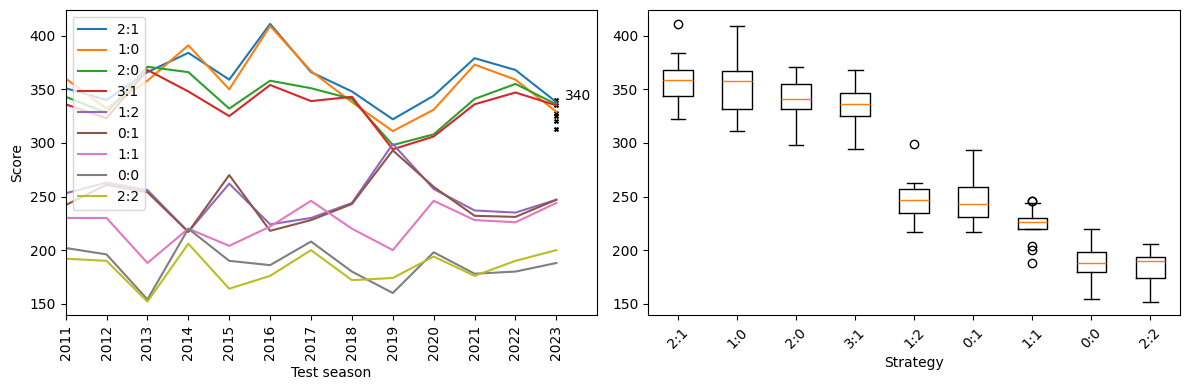

In [4]:

splits = cross_val_splits(df_matches)
y_train = df_matches[["host_goals", "guest_goals"]].values

static_results = [
    [0, 0],
    [1, 0], 
    [0, 1],
    [1, 1],
    [2, 0], 
    [2, 1],
    [1, 2],
    [2, 2],
    [3, 1]
]

models = [StaticEstimator(result) for result in static_results]
labels = [f"{r[0]}:{r[1]}" for r in static_results]
scores = [cross_val_score(model, df_matches, y_train, cv=splits, scoring=kicktipp_scoring) for model in models]

fig, axs = cross_val_plot(df_matches, splits, labels, scores)
real_results = [340, 335, 328, 325, 320, 313]
axs[0].scatter([12] * len(real_results), real_results, s=8, marker="x", color="black")
axs[0].text(12.2, 340, max(real_results))
axs[0].set_xlim(0, 13)


## Based on table 

Table-based:	375.308 +- 26.034
2:1:	359.692 +- 22.331


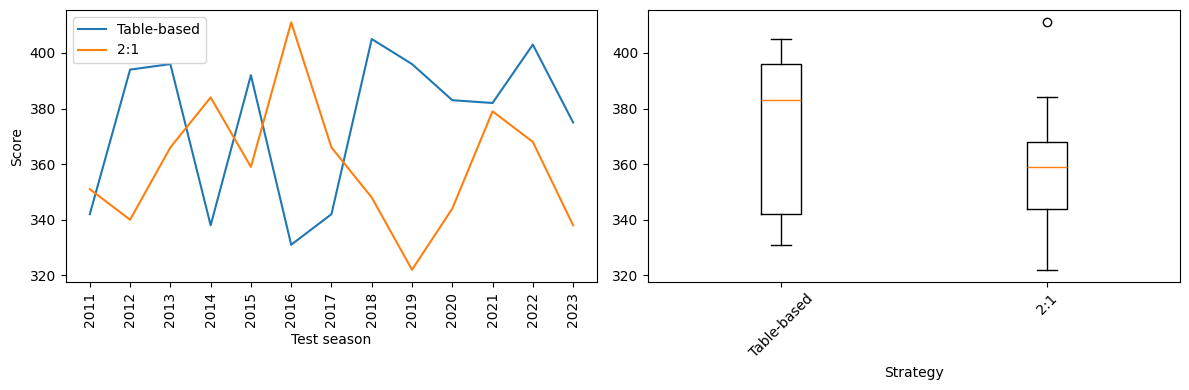

In [5]:

models = [StaticEstimator([2, 1]), LatestTableEstimator()]
labels = ["2:1", "Table-based"]
scores = [cross_val_score(model, df_matches, y_train, cv=splits, scoring=kicktipp_scoring) for model in models]

fig, axs = cross_val_plot(df_matches, splits, labels, scores)

# Matches with team context

In [6]:
df_matches = df_matches.fillna(0)
df_matches.tail()

,id,match_day,season,host_id,host_name,guest_id,guest_name,host_goals,guest_goals,host_last_season_draws,...,host_horizon_wins,host_horizon_draws,host_horizon_defeats,guest_horizon_points,guest_horizon_goals,guest_horizon_opponent_goals,guest_horizon_goal_diff,guest_horizon_wins,guest_horizon_draws,guest_horizon_defeats
4279,66932,34,2023,131,Wolfsburg,81,Mainz,1.0,3.0,10.0,...,14.000000,8.666667,11.333333,43.666667,47.666667,52.000000,-4.333333,11.666667,8.666667,13.666667
4280,66933,34,2023,175,Hoffenheim,40,Bayern,4.0,2.0,6.0,...,11.333333,7.666667,15.000000,75.333333,96.000000,39.666667,56.333333,23.000000,6.333333,4.666667
4281,66934,34,2023,134,Bremen,129,Bochum,4.0,1.0,6.0,...,8.500000,8.000000,17.500000,38.500000,39.000000,62.000000,-23.000000,11.000000,5.500000,17.500000
4282,66935,34,2023,16,Stuttgart,87,Gladbach,4.0,0.0,12.0,...,8.666667,11.000000,14.333333,45.666667,56.666667,57.333333,-0.666667,12.000000,9.666667,12.333333
4283,66936,34,2023,199,Heidenheim,65,Köln,4.0,1.0,0.0,...,0.000000,0.000000,0.000000,42.333333,45.000000,54.333333,-9.333333,10.666667,10.333333,13.000000


In [7]:
X_all = df_matches.drop(columns=["host_name", "guest_name", "host_goals", "guest_goals"])
y_all = df_matches[["host_goals", "guest_goals"]].values
print(X_all.columns)

Index(['id', 'match_day', 'season', 'host_id', 'guest_id',
       'host_last_season_draws', 'host_last_season_goal_diff',
       'host_last_season_goals', 'host_last_season_defeats',
       'host_last_season_matches', 'host_last_season_opponent_goals',
       'host_last_season_points', 'host_last_season_wins',
       'guest_last_season_draws', 'guest_last_season_goal_diff',
       'guest_last_season_goals', 'guest_last_season_defeats',
       'guest_last_season_matches', 'guest_last_season_opponent_goals',
       'guest_last_season_points', 'guest_last_season_wins',
       'host_horizon_points', 'host_horizon_goals',
       'host_horizon_opponent_goals', 'host_horizon_goal_diff',
       'host_horizon_wins', 'host_horizon_draws', 'host_horizon_defeats',
       'guest_horizon_points', 'guest_horizon_goals',
       'guest_horizon_opponent_goals', 'guest_horizon_goal_diff',
       'guest_horizon_wins', 'guest_horizon_draws', 'guest_horizon_defeats'],
      dtype='object')


## Random Forest

In [8]:
splits = cross_val_splits(X_all, start=3)

def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 50, 50)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    estimator = RoundingWrapper(RandomForestRegressor(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=4
    ))
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf", load_if_exists=True)
rf_study.optimize(objective, n_trials=2 if DEBUG else 100)
print(rf_study.best_value, rf_study.best_params)

[I 2024-09-09 17:47:38,967] A new study created in RDB with name: rf
[I 2024-09-09 17:47:41,640] Trial 0 finished with value: 340.3636363636364 and parameters: {'criterion': 'friedman_mse', 'max_depth': 14, 'n_estimators': 50, 'min_samples_split': 27}. Best is trial 0 with value: 340.3636363636364.
[I 2024-09-09 17:47:42,622] Trial 1 finished with value: 342.90909090909093 and parameters: {'criterion': 'friedman_mse', 'max_depth': 2, 'n_estimators': 50, 'min_samples_split': 4}. Best is trial 1 with value: 342.90909090909093.
[I 2024-09-09 17:47:44,564] Trial 2 finished with value: 372.72727272727275 and parameters: {'criterion': 'poisson', 'max_depth': 10, 'n_estimators': 50, 'min_samples_split': 100}. Best is trial 2 with value: 372.72727272727275.
[I 2024-09-09 17:47:46,106] Trial 3 finished with value: 370.54545454545456 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 50, 'min_samples_split': 32}. Best is trial 2 with value: 372.72727272727275.
[I 2024

392.0 {'criterion': 'poisson', 'max_depth': 2, 'n_estimators': 50, 'min_samples_split': 53}


In [9]:
def build_rf_model(study):
    best_params = study.best_params
    return RoundingWrapper(RandomForestRegressor(
        n_estimators=best_params['n_estimators'], 
        criterion=best_params['criterion'], 
        max_depth=best_params['max_depth'], 
        min_samples_split=best_params['min_samples_split'],
        n_jobs=4
    ))
    

## Gradient Boosting

In [10]:
def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 50, 50)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = RoundingWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ))
    elif algo == "lgbm":
        estimator = RoundingWrapper(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        )))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb", load_if_exists=True)
gb_study.optimize(objective, n_trials=2 if DEBUG else 200)
print(gb_study.best_value, gb_study.best_params)

[I 2024-09-09 17:58:43,458] A new study created in RDB with name: gb
[I 2024-09-09 17:58:43,722] Trial 0 finished with value: 310.90909090909093 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 10, 'lambda': 1.258370298460946, 'alpha': 1.2073048135861892, 'learning_rate': 0.32492524648310295, 'num_leaves': 2, 'min_child_weight': 2.2468218081443947, 'objective-lgbm': 'mae'}. Best is trial 0 with value: 310.90909090909093.
[I 2024-09-09 17:58:44,118] Trial 1 finished with value: 335.27272727272725 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 4, 'lambda': 1.1517998000697947, 'alpha': 0.048104164114305625, 'learning_rate': 0.2500314631018182, 'num_leaves': 25, 'min_child_weight': 6.279768750205356, 'objective-lgbm': 'mae'}. Best is trial 1 with value: 335.27272727272725.
[I 2024-09-09 17:58:44,567] Trial 2 finished with value: 332.1818181818182 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 8, 'lambda': 0.6203250848195287, 'alpha': 1.

388.3636363636364 {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 10, 'lambda': 1.226209613660882, 'alpha': 0.44758926932555276, 'learning_rate': 0.03431079942876073, 'num_leaves': 4, 'min_child_weight': 4.430424515443841, 'objective-lgbm': 'poisson'}


In [11]:
def build_gb_model(study):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda=params["lambda"]
    reg_alpha=params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves=params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    if algo == "xgb":
        estimator = RoundingWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-xgb"],
        ))
    elif algo == "lgbm":
        estimator = RoundingWrapper(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-lgbm"],
        )))
    return estimator
    

## SVR

In [23]:
def objective(trial: Trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    if kernel == "poly":
        degree = trial.suggest_int("degree", 3, 8)
    else:
        degree = 3
    estimator = RoundingWrapper(MultiOutputRegressor(SVR(
        kernel=kernel,
        degree=degree,
        C=trial.suggest_float("C", 0.0, 3.0)
    )))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

svr_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="svr", load_if_exists=True)
svr_study.optimize(objective, n_trials=2 if DEBUG else 30)
print(svr_study.best_value, svr_study.best_params)


[I 2024-09-09 18:16:28,048] Using an existing study with name 'svr' instead of creating a new one.
[I 2024-09-09 18:16:36,531] Trial 30 finished with value: 304.27272727272725 and parameters: {'kernel': 'poly', 'degree': 7, 'C': 2.025203599790604}. Best is trial 0 with value: 357.0.
[I 2024-09-09 18:16:46,480] Trial 31 finished with value: 353.54545454545456 and parameters: {'kernel': 'linear', 'C': 1.4562802624407536}. Best is trial 0 with value: 357.0.
[I 2024-09-09 18:16:51,138] Trial 32 finished with value: 356.8181818181818 and parameters: {'kernel': 'linear', 'C': 0.33957691948420665}. Best is trial 0 with value: 357.0.
[I 2024-09-09 18:16:57,227] Trial 33 finished with value: 356.1818181818182 and parameters: {'kernel': 'linear', 'C': 0.5877403363055437}. Best is trial 0 with value: 357.0.
[I 2024-09-09 18:17:03,310] Trial 34 finished with value: 356.1818181818182 and parameters: {'kernel': 'linear', 'C': 0.6121266705508319}. Best is trial 0 with value: 357.0.
[I 2024-09-09 18:1

357.3636363636364 {'kernel': 'linear', 'C': 0.4067378193678877}


In [24]:
def build_svr_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(MultiOutputRegressor(SVR(
        kernel=params["kernel"],
        degree=params["degree"] if "degree" in params else 3,
        C=params["C"]
    )))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

## KNN Regressor

In [25]:


def objective(trial: Trial):
    estimator = RoundingWrapper(KNeighborsRegressor(
        n_neighbors=trial.suggest_int("n_neighbors", 5, 50),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric=trial.suggest_categorical("metric", ["cityblock", "cosine", "euclidean", "l1"])
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

knn_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="knn", load_if_exists=True)
knn_study.optimize(objective, n_trials=20 if DEBUG else 200)
print(knn_study.best_value, knn_study.best_params)

def build_knn_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(KNeighborsRegressor(
        n_neighbors=params["n_neighbors"],
        weights=params["weights"],
        metric=params["metric"]
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-09 18:19:28,216] Using an existing study with name 'knn' instead of creating a new one.


[I 2024-09-09 18:19:28,368] Trial 100 finished with value: 367.09090909090907 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 21 with value: 372.45454545454544.
[I 2024-09-09 18:19:28,557] Trial 101 finished with value: 372.45454545454544 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 21 with value: 372.45454545454544.
[I 2024-09-09 18:19:28,729] Trial 102 finished with value: 367.3636363636364 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 21 with value: 372.45454545454544.
[I 2024-09-09 18:19:28,867] Trial 103 finished with value: 363.0 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 21 with value: 372.45454545454544.
[I 2024-09-09 18:19:28,991] Trial 104 finished with value: 357.72727272727275 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'l1'}. Best is trial 21 with value: 372.454545454545

372.45454545454544 {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'l1'}


## MLP

In [26]:
def objective(trial: Trial):
    size_1 = trial.suggest_int("size_1", 4, 30)
    size_2 = trial.suggest_int("size_2", 4, 20)
    estimator = RoundingWrapper(MLPRegressor(
        hidden_layer_sizes=(size_1, size_2),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.0001, 0.01),
        max_iter=500
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

mlp_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="mlp", load_if_exists=True)
mlp_study.optimize(objective, n_trials=2 if DEBUG else 100)
print(mlp_study.best_value, mlp_study.best_params)

def build_mlp_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(MLPRegressor(
        hidden_layer_sizes=(params["size_1"], params["size_2"]),
        learning_rate_init=params["learning_rate_init"]
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-09 18:19:57,991] Using an existing study with name 'mlp' instead of creating a new one.


[I 2024-09-09 18:20:02,676] Trial 100 finished with value: 335.90909090909093 and parameters: {'size_1': 26, 'size_2': 8, 'learning_rate_init': 0.003565123410591998}. Best is trial 53 with value: 375.45454545454544.
[I 2024-09-09 18:20:05,589] Trial 101 finished with value: 356.09090909090907 and parameters: {'size_1': 5, 'size_2': 11, 'learning_rate_init': 0.003988427055552012}. Best is trial 53 with value: 375.45454545454544.
[I 2024-09-09 18:20:08,462] Trial 102 finished with value: 358.90909090909093 and parameters: {'size_1': 4, 'size_2': 12, 'learning_rate_init': 0.0032811702004522415}. Best is trial 53 with value: 375.45454545454544.
[I 2024-09-09 18:20:12,217] Trial 103 finished with value: 351.6363636363636 and parameters: {'size_1': 5, 'size_2': 11, 'learning_rate_init': 0.002775750720491214}. Best is trial 53 with value: 375.45454545454544.
[I 2024-09-09 18:20:14,906] Trial 104 finished with value: 356.1818181818182 and parameters: {'size_1': 4, 'size_2': 5, 'learning_rate_i

377.90909090909093 {'size_1': 4, 'size_2': 7, 'learning_rate_init': 0.0013042508751177405}


/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

gb:	388.364 +- 16.216
rf:	387.273 +- 15.498
table-based:	376.636 +- 25.819
knn:	372.455 +- 26.586
svr:	357.364 +- 26.144
mlp:	353.091 +- 19.561


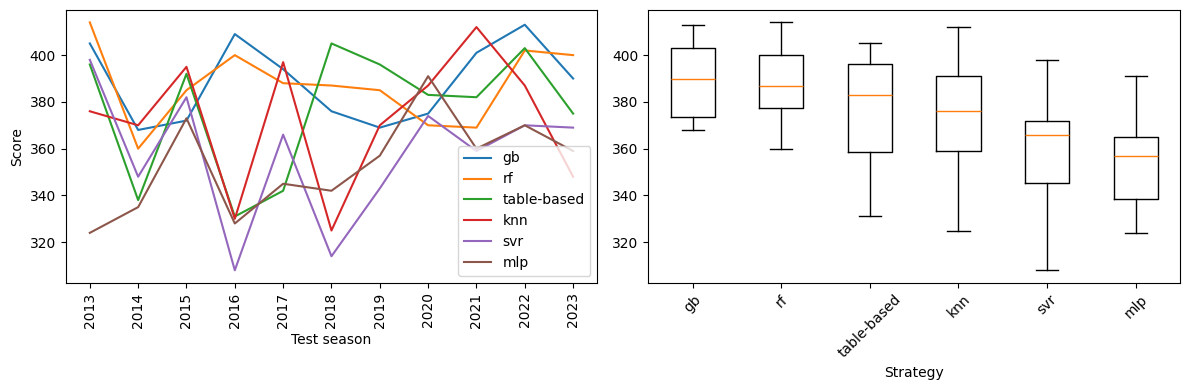

In [27]:

models = {
    "table-based": LatestTableEstimator(),
    "rf": build_rf_model(rf_study),
    "gb": build_gb_model(gb_study),
    "svr": build_svr_model(svr_study),
    "knn": build_knn_model(knn_study),
    "mlp": build_mlp_model(mlp_study)
}

labels = list(models.keys())
scores = [cross_val_score(models[name], X_all, y_all, cv=splits, scoring=kicktipp_scoring) for name in models.keys()]

fig, axs = cross_val_plot(df_matches, splits, labels, scores)


In [28]:
model = build_gb_model(gb_study)
train_idx, test_idx = splits[-2]
X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred_raw = model.regressor.predict(X_train)

df_full_train = df_matches.iloc[train_idx].copy()
df_full_train["team1Goals_pred"] = y_train_pred[:, 0]
df_full_train["team2Goals_pred"] = y_train_pred[:, 1]
df_full_train["team1Goals_pred_raw"] = y_train_pred_raw[:, 0]
df_full_train["team2Goals_pred_raw"] = y_train_pred_raw[:, 1]
df_full_train[["season", "match_day", "host_name", "guest_name", "host_goals", "guest_goals", "team1Goals_pred", "team2Goals_pred"]]

,season,match_day,host_name,guest_name,host_goals,guest_goals,team1Goals_pred,team2Goals_pred
0,2010,1,Bayern,Wolfsburg,2.0,1.0,2.0,1.0
1,2010,1,Hoffenheim,Bremen,4.0,1.0,2.0,1.0
2,2010,1,Gladbach,Nürnberg,1.0,1.0,2.0,1.0
3,2010,1,Köln,Kaiserslautern,1.0,3.0,2.0,1.0
4,2010,1,Freiburg,St. Pauli,1.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...
3667,2021,34,Gladbach,Hoffenheim,5.0,1.0,2.0,1.0
3668,2021,34,Mainz,Frankfurt,2.0,2.0,1.0,1.0
3669,2021,34,Stuttgart,Köln,2.0,1.0,2.0,1.0
3670,2021,34,Union Berlin,Bochum,3.0,2.0,2.0,1.0


<Axes: >

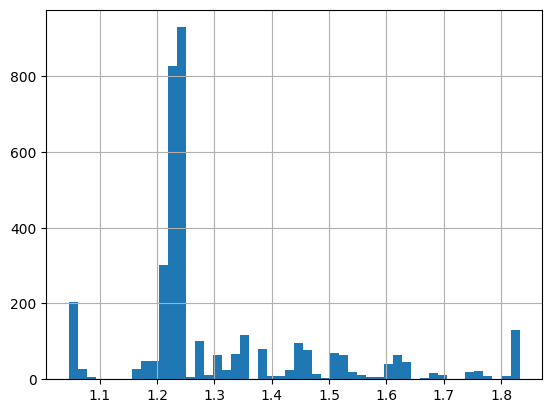

In [29]:
df_full_train["team2Goals_pred_raw"].hist(bins=50)

In [30]:
df_full_train[["team1Goals_pred", "team2Goals_pred"]].value_counts()

team1Goals_pred  team2Goals_pred
2.0              1.0                2939
1.0              2.0                 510
                 1.0                 185
2.0              2.0                  38
Name: count, dtype: int64

# Difference Regression

## KNN Diff

In [31]:
from model.wrapper import DifferenceWrapper


def objective(trial: Trial):
    estimator = DifferenceWrapper(KNeighborsRegressor(
        n_neighbors=trial.suggest_int("n_neighbors", 5, 50),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric=trial.suggest_categorical("metric", ["cityblock", "cosine", "euclidean", "l1"]),
    ), base=trial.suggest_float("base", 0.0, 2.0))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

knn_diff_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="knn_diff", load_if_exists=True)
knn_diff_study.optimize(objective, n_trials=20 if DEBUG else 100)
print(knn_diff_study.best_value, knn_diff_study.best_params)

def build_knn_model(study: Study):
    params = study.best_params
    estimator = DifferenceWrapper(KNeighborsRegressor(
        n_neighbors=params["n_neighbors"],
        weights=params["weights"],
        metric=params["metric"]
    ), base=params["base"])
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-09 18:26:42,927] Using an existing study with name 'knn_diff' instead of creating a new one.
[I 2024-09-09 18:26:43,141] Trial 100 finished with value: 289.09090909090907 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'cosine', 'base': 1.5118767594156075}. Best is trial 22 with value: 371.0.
[I 2024-09-09 18:26:43,321] Trial 101 finished with value: 368.54545454545456 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'cosine', 'base': 1.4609271539448452}. Best is trial 22 with value: 371.0.
[I 2024-09-09 18:26:43,505] Trial 102 finished with value: 368.54545454545456 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'cosine', 'base': 1.4601021266789298}. Best is trial 22 with value: 371.0.
[I 2024-09-09 18:26:43,689] Trial 103 finished with value: 346.72727272727275 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'cosine', 'base': 0.9592156708857873}. Best is trial 22 with value: 371.0.
[I 2024-

372.45454545454544 {'n_neighbors': 46, 'weights': 'distance', 'metric': 'cosine', 'base': 1.48703454381635}


## GB Diff

In [32]:

def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 50, 50)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = DifferenceWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ), base=trial.suggest_int("base", 0.0, 2.0))
    elif algo == "lgbm":
        estimator = DifferenceWrapper(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        ), base=trial.suggest_int("base", 0.0, 2.0))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_diff_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb_diff", load_if_exists=True)
gb_diff_study.optimize(objective, n_trials=2 if DEBUG else 200)
print(gb_diff_study.best_value, gb_diff_study.best_params)

[I 2024-09-09 18:27:00,598] Using an existing study with name 'gb_diff' instead of creating a new one.


[I 2024-09-09 18:27:01,000] Trial 200 finished with value: 351.6363636363636 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 7, 'lambda': 1.9203120451883113, 'alpha': 0.6535550361165179, 'learning_rate': 0.3125256909877707, 'num_leaves': 10, 'min_child_weight': 0.47474733876687436, 'objective-lgbm': 'poisson', 'base': 1}. Best is trial 151 with value: 357.27272727272725.
[I 2024-09-09 18:27:01,256] Trial 201 finished with value: 348.90909090909093 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 7, 'lambda': 1.7699614057688706, 'alpha': 0.699726279238171, 'learning_rate': 0.3157664087368112, 'num_leaves': 8, 'min_child_weight': 1.4983806690503982, 'objective-lgbm': 'poisson', 'base': 1}. Best is trial 151 with value: 357.27272727272725.
[I 2024-09-09 18:27:01,490] Trial 202 finished with value: 354.27272727272725 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 8, 'lambda': 1.865160120559332, 'alpha': 0.9275978538132149, 'learning_rat

361.27272727272725 {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 10, 'lambda': 0.2091679197221692, 'alpha': 1.0119925839886494, 'learning_rate': 0.24602095114460762, 'num_leaves': 9, 'min_child_weight': 7.205219418487241, 'objective-lgbm': 'poisson', 'base': 1}
